# Maximum Entropy Text Classifier

Classifying Reuters articles following [this](http://tongzhang-ml.org/papers/ir01_textcat.pdf) paper by Zhang and Oles. 

## Load data

We'll use the nltk.corpus.reuters corpus of news articles.

The Reuters Corpus contains 10,788 news documents totaling 1.3 million words. The documents have been classified into 90 topics, and grouped into training and testing sets.

We are going to choose a single category.

In [25]:
import nltk
import pandas as pd
from nltk.corpus import reuters
from tqdm import tqdm

CHOSEN_CATEGORY = 'money-fx'

training_articles = []
training_labels = []
testing_articles = []
testing_labels = []

# Loop over every document in the corpus
for fileid in tqdm(reuters.fileids(), unit='article'):
    
    # Binary categorization
    if CHOSEN_CATEGORY in reuters.categories(fileid):
        label = 1
    else:
        label = -1

    # Extract list of tokens for this document
    article = reuters.words(fileid)
    
    # Put data in train or test set
    if 'training' in fileid:
        training_articles.append(article)
        training_labels.append(label)
    elif 'test' in fileid:
        testing_articles.append(article)
        testing_labels.append(label)
    else:
        print("Unrecognized document %s" % fileid)

# Create Pandas data frames
training_corpus = pd.DataFrame({'tokens': training_articles, 'class': training_labels})
testing_corpus = pd.DataFrame({'tokens': testing_articles, 'class': testing_labels})

print(training_corpus.head().to_string(index=False))

print()
print("Size of training corpus = %d documents" % len(training_corpus.index))
print("Size of testing corpus = %d documents" % len(testing_corpus.index))

class_document_count = training_corpus['class'].value_counts()
print()
print("Training corpus class distribution:\n", class_document_count)

100%|██████████| 10788/10788 [00:00<00:00, 30104.10article/s]

class                                             tokens
   -1  (BAHIA, COCOA, REVIEW, Showers, continued, thr...
   -1  (COMPUTER, TERMINAL, SYSTEMS, &, lt, ;, CPML, ...
   -1  (N, ., Z, ., TRADING, BANK, DEPOSIT, GROWTH, R...
   -1  (NATIONAL, AMUSEMENTS, AGAIN, UPS, VIACOM, &, ...
   -1  (ROGERS, &, lt, ;, ROG, >, SEES, 1ST, QTR, NET...

Size of training corpus = 7769 documents
Size of testing corpus = 3019 documents

Training corpus class distribution:
 -1    7231
 1     538
Name: class, dtype: int64


## Feature Selection

We'll select features using information gain, as described in Section 2.2 of [this paper](http://nyc.lti.cs.cmu.edu/yiming/Publications/yang-icml97.pdf). The information gain for any token w is:

$$
G(w) = -\sum\limits_{i=1}^m Pr(c_i) * log Pr(c_i) \\
+ Pr(w) \sum\limits_{i=1}^m Pr(c_i \mid w) * log Pr(c_i \mid w) \\
+ Pr(\widetilde{w}) \sum\limits_{i=1}^m Pr(c_i \mid \widetilde{w}) * log Pr(c_i \mid \widetilde{w})
$$

First we'll calculate all possible features - the vocabulary of our training set. Then we'll compute the information gain for every one of those features, order them, and select the top 1000. Since we're just sorting the information gains by feature, the $-\sum\limits_{i=1}^m Pr(c_i) * log Pr(c_i)$ term which is constant across all features won't affect our results. Thus we won't bother computing it.

In [2]:
# First figure out all possible features. In this case that's the vocabulary
vocabulary = set()
for _, document in tqdm(training_corpus.iterrows(), total=len(training_corpus), unit='document'):
    for token in document['tokens']:
        vocabulary.add(token)

vocabulary = list(vocabulary)
print("Some example features: ", vocabulary[:10])

100%|██████████| 7769/7769 [00:02<00:00, 2722.74document/s]

Some example features:  ['pointing', 'Steels', 'thin', 'houseware', 'bills', 'Number', 'BI', '091', 'POSTINGS', 'renewals']


Now we'll compute the information gain for every feature in our vocabulary. We won't do this in a modular way since we need to optimize this part for speed. First for the conditional probabilities, we'll count for each (feature, class) pair how many documents of that class contain that feature (so binary counting).

In [3]:
from collections import defaultdict

docs_with_feature = defaultdict(lambda: defaultdict(int))

for _, document in tqdm(training_corpus.iterrows(), total=len(training_corpus), unit='document'):  # for each document
    tokens_binary = set(document['tokens'])  # binarize document tokens (for speed)
    for feature in vocabulary:  # for every feature
        if feature in tokens_binary:  # if feature shows up in document
            docs_with_feature[feature][document['class']] += 1  # add 1 to (feature, class) count

100%|██████████| 7769/7769 [00:38<00:00, 199.65document/s]


Next for the probabilities of each feature, we'll count the number of times each feature occurs, as well as the total number of tokens that are in our corpus.

In [4]:
total_count = 0  # total number of tokens across all documents
feature_count = defaultdict(int)
for _, document in tqdm(training_corpus.iterrows(), total=len(training_corpus), unit='document'):
    total_count += len(document['tokens'])
    
    for token in document['tokens']:
        feature_count[token] += 1
        
print("Total token count: {}".format(total_count))
print("Some example feature counts: {}".format(list(feature_count.items())[:10]))

100%|██████████| 7769/7769 [00:02<00:00, 3051.77document/s]

Total token count: 1253696
Some example feature counts: [('pointing', 3), ('the', 43203), ('Steels', 1), ('thin', 8), ('Kizito', 2), ('houseware', 1), ('processing', 74), ('average', 424), ('kwacha', 21), ('bills', 186)]


Time to put it all together and get the information gain per feature.

In [5]:
import numpy as np

set_of_classes = training_corpus['class'].unique()

information_gain = defaultdict(int)
for feature in tqdm(vocabulary, unit='feature'):
    
    pr_w = feature_count[feature] / total_count
    pr_not_w = 1.0 - pr_w
    
    # A dictionary with (class, count) key-value pairs
    docs_with_feature_in_class = docs_with_feature[feature]
    
    # The sum over all classes gives the total number of documents that had this feature
    num_docs_with_feature = sum(docs_with_feature_in_class.values())
    
    # The total number of documents in the corpus minus the number of documents with this feature,
    # gives the number of documents without this feature
    num_docs_total = len(training_corpus)
    num_docs_with_not_feature = num_docs_total - num_docs_with_feature
    
    for c in set_of_classes:
        # Refer to the information gain formula
        # We use add-1 smoothing to avoid errors with 0 counts
        if (num_docs_with_feature == 0):
            print("YUCK")
        pr_c_given_w = (docs_with_feature_in_class[c] + 1) / num_docs_with_feature
        
        if (num_docs_with_not_feature == 0):
            print("OH NO")
        docs_with_not_feature_in_class_c = class_document_count[c] - docs_with_feature_in_class[c]
        pr_c_given_not_w = (docs_with_not_feature_in_class_c + 1) / num_docs_with_not_feature
        
        if (pr_c_given_w == 0):
            print("OH NOX")
        if (pr_c_given_not_w == 0):
            print("OH NOZ")
        feature_class_info = pr_c_given_w * np.log(pr_c_given_w)
        not_feature_class_info = pr_c_given_not_w * np.log(pr_c_given_not_w)
        
        information_gain[feature] += (pr_w * feature_class_info) + (pr_not_w * not_feature_class_info)

100%|██████████| 35247/35247 [00:01<00:00, 28488.31feature/s]


Now to sort and grab the top 1000.

In [6]:
sorted_features = sorted(information_gain, key=information_gain.get)

top_1000_features = sorted_features[:1000]
print("Top 10 features: {}".format(top_1000_features[:10]))

Top 10 features: [';', '&', 'lt', '>', 'cts', '000', 'vs', 'company', 'mln', 'dlrs']


## Document Vectorization

Now we'll need to convert each training document into a (featureset, label) tuple. A featureset is a dictionary with features as keys and feature counts as values. This is the format that nltk will want.

In [7]:
top_1000_features = set(top_1000_features)  # for speed of 'in' operator

train = []
for _, document in tqdm(training_corpus.iterrows(), total=len(training_corpus), unit='document'):
    
    featureset = defaultdict(int)
    for feature in document['tokens']:
        if feature in top_1000_features:
            featureset[feature] += 1
            
    label = str(document['class'])

    train.append((featureset, label))

100%|██████████| 7769/7769 [00:02<00:00, 2809.35document/s]


Similarly, we'll convert each testing document into just a featureset. We'll hold onto the testing labels for validation later.

In [8]:
test = []
test_labels = []
for _, document in tqdm(testing_corpus.iterrows(), total=len(testing_corpus), unit='document'):

    featureset = defaultdict(int)
    for feature in document['tokens']:
        if feature in top_1000_features:
            featureset[feature] += 1
    
    label = str(document['class'])
    
    test.append(featureset)
    test_labels.append(label)

100%|██████████| 3019/3019 [00:01<00:00, 2243.05document/s]


## Training a Maximum Entropy Classifier

In [9]:
from nltk.classify import maxent

encoding = maxent.TypedMaxentFeatureEncoding.train(
    train, count_cutoff=3, alwayson_features=True)

classifier = maxent.MaxentClassifier.train(
    train, bernoulli=False, encoding=encoding, trace=0)

## Testing our model

In [10]:
predictions = classifier.classify_many(test)

In [31]:
predictions = np.array(predictions)
test_labels = np.array(test_labels)

POSITIVE_CLASS = '1'
NEGATIVE_CLASS = '-1'

predicted_positives = (predictions == POSITIVE_CLASS).sum()

true_positives = 0
for i in range(len(predictions)):
    # positive prediction and positive label
    if predictions[i] == POSITIVE_CLASS and test_labels[i] == POSITIVE_CLASS:
        true_positives += 1
        
print("Number of predicted positives: {}".format(predicted_positives))
print("Number of true positives: {}".format(true_positives))

Number of predicted positives: 106
Number of true positives: 27


In [32]:
predicted_negatives = (predictions == NEGATIVE_CLASS).sum()

true_negatives = 0
for i in range(len(predictions)):
    # negative prediction and negative label
    if predictions[i] == NEGATIVE_CLASS and test_labels[i] == NEGATIVE_CLASS:
        true_negatives += 1
        
print("Number of predicted negatives: {}".format(predicted_negatives))
print("Number of true negatives: {}".format(true_negatives))

Number of predicted negatives: 2913
Number of true negatives: 2761


In [33]:
# reference: https://en.wikipedia.org/wiki/F1_score

precision = true_positives / predicted_positives

recall = true_negatives / predicted_negatives

F1_score = 2 * precision * recall / (precision + recall)

print("Precision = {}".format(precision))
print("Recall = {}".format(recall))
print("F1 = {}".format(F1_score))

Precision = 0.25471698113207547
Recall = 0.94782011671816
F1 = 0.4015275357713221


Ok, we got some results. The recall is pretty good, but the precision doesn't look great. This makes some sense because our data set is skewed - there are more negative examples than positive ones. Let's explore that real quick.

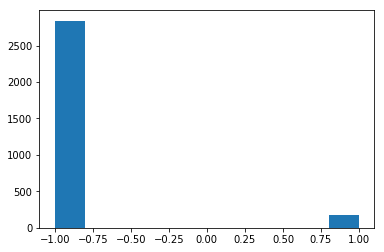

In [35]:
import matplotlib.pyplot as plt

plt.hist(test_labels.astype(np.int32))
plt.show()

In [49]:
num_positive_test_samples = (test_labels == '1').sum()
num_negative_test_samples = (test_labels == '-1').sum()

print("Number of positive samples in test set: {}".format(num_positive_test_samples))
print("Number of negative samples in test set: {}".format(num_negative_test_samples))
print("Recall of trivial model that always classifies input documents as negative: {}".format(num_negative_test_samples / (num_positive_test_samples + num_negative_test_samples)))

Number of positive samples in test set: 179
Number of negative samples in test set: 2840
Recall of trivial model that always classifies input documents as negative: 0.9407088439880755


Ok, so it looks like if we just always classified input documents as negative, then we would have a recall of 94.07%. That's very close to our model's recall of 94.78%. But hey, at least our model is marginally better than nothing, and the precision of our model is better than trivial model's 0%. Our model correctly classifies positive documents 25.47% of the time.